# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_039  A0A075B7D0        20.106
Sample_125  Q8TBP5            18.488
Sample_073  P54803            14.491
Sample_196  Q9UBR2            18.537
Sample_066  P00740;P00740-2   16.543
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups
Sample_173  O76061           15.927
Sample_107  Q7Z7M8           11.821
Sample_108  P05451           12.736
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.158
            A0A075B6Q5                 12.823
            A0A075B6R2                 14.141
            A0A075B6S5                 13.347
            A0A087WSY4                 13.875
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.540
            Q9UI40;Q9UI40-2            13.390
            Q9UIW2                     11.657
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.857
            Q9UP79                     10.904
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.181,15.050,16.842,19.863,15.805,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.556,19.067,...,15.528,15.576,14.375,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.098,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.280,17.705,17.039,15.683,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.756,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.096,15.345,17.084,18.708,14.249,19.433,11.816,10.843
Sample_207,15.739,16.877,15.469,16.898,15.397,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.082,12.815,13.686,13.302,12.958,13.798,13.682,13.050,13.320,13.427
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.882,19.067,16.127,...,12.686,11.603,11.834,13.003,12.957,14.596,13.831,12.744,12.965,13.668
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.734,13.626,12.229,12.880,13.861,12.381,13.008,12.579,13.024,13.078
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.551,12.666,11.554,13.407,13.436,12.020,13.320,11.931,13.039,13.630
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.098,12.290,12.305,12.649,12.634,11.751,12.843,13.939,11.924,12.570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.632,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 365.87it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.71it/s]

100%|██████████| 2/2 [00:00<00:00,  7.64it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.48it/s]

100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.19it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.17it/s]

100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.00it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.22it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.81it/s]

100%|██████████| 5/5 [00:01<00:00,  4.50it/s]

100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.19it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.92it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.88it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.98it/s]

100%|██████████| 6/6 [00:01<00:00,  3.87it/s]

100%|██████████| 6/6 [00:01<00:00,  3.99it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.37it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.30it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.70it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.78it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.73it/s]

100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.93it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.05it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.48it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.28it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.37it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.53it/s]

100%|██████████| 8/8 [00:02<00:00,  3.70it/s]

100%|██████████| 8/8 [00:02<00:00,  3.69it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.61it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.50it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.02it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.39it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.10it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.13it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.15it/s]

100%|██████████| 9/9 [00:02<00:00,  3.27it/s]

100%|██████████| 9/9 [00:02<00:00,  3.48it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.56it/s]

 30%|███       | 3/10 [00:00<00:01,  3.91it/s]

 40%|████      | 4/10 [00:01<00:01,  3.49it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.40it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.57it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.50it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.65it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.68it/s]

100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.34it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.24it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.00it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.46it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.39it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.23it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.51it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.61it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.75it/s]

100%|██████████| 11/11 [00:02<00:00,  3.91it/s]

100%|██████████| 11/11 [00:02<00:00,  3.85it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.37it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.35it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.03it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.67it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.44it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.28it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.32it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.40it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.51it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.59it/s]

100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.51it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.00it/s]

 31%|███       | 4/13 [00:00<00:02,  4.03it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.61it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.27it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.72it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.64it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.50it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.44it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.70it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.00it/s]

100%|██████████| 13/13 [00:04<00:00,  3.25it/s]

100%|██████████| 13/13 [00:04<00:00,  3.13it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.73it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.94it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.25it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.67it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.22it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.11it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.02it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.85it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  2.88it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.94it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.93it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.77it/s]

100%|██████████| 14/14 [00:04<00:00,  2.85it/s]

100%|██████████| 14/14 [00:04<00:00,  3.19it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.57it/s]

 20%|██        | 3/15 [00:00<00:02,  5.30it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.12it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.45it/s]

 40%|████      | 6/15 [00:01<00:02,  3.20it/s]

 47%|████▋     | 7/15 [00:01<00:02,  2.99it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.10it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.29it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.40it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.32it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.40it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.57it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.64it/s]

100%|██████████| 15/15 [00:04<00:00,  3.69it/s]

100%|██████████| 15/15 [00:04<00:00,  3.57it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.036 0.005          0.734 0.370       0.105   
2             0.003 0.000      0.035 0.001          0.697 0.089       0.600   
3             0.003 0.000      0.035 0.002          0.690 0.094       0.596   
4             0.003 0.000      0.035 0.005          0.741 0.094       0.620   
5             0.003 0.000      0.035 0.001          0.706 0.089       0.673   
6             0.003 0.000      0.036 0.003          0.787 0.087       0.788   
7             0.003 0.000      0.036 0.006          0.788 0.088       0.791   
8             0.004 0.003      0.040 0.010          0.805 0.086       0.815   
9             0.004 0.002      0.040 0.012          0.801 0.081       0.819   
10            0.004 0.002      0.038 0.013          0.799 0.082       0.820   
11            0.003 0.000      0.038 0.010          0.805 0.086       0.808   
12            0.004 0.002      0.038 0.013          0.803 0.087       0.802   
13            0.006 0.005      0.055 0.021          0.809 0.089       0.808   
14            0.004 0.003      0.042 0.016          0.800 0.097       0.807   
15            0.006 0.005      0.055 0.022          0.798 0.095       0.806   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.177 0.128                  0.545 0.041        0.844   
2          0.102   0.639 0.077                  0.702 0.057        0.774   
3          0.108   0.633 0.080                  0.698 0.059        0.768   
4          0.115   0.668 0.085                  0.729 0.060        0.780   
5          0.112   0.683 0.075                  0.732 0.058        0.798   
6          0.106   0.782 0.073                  0.814 0.062        0.895   
7          0.106   0.785 0.074                  0.816 0.063        0.895   
8          0.109   0.806 0.075                  0.834 0.064        0.909   
9          0.106   0.805 0.072                  0.834 0.062        0.909   
10         0.108   0.805 0.073                  0.833 0.063        0.907   
11         0.101   0.802 0.071                  0.831 0.061        0.907   
12         0.102   0.798 0.074                  0.828 0.063        0.904   
13         0.100   0.804 0.070                  0.832 0.059        0.913   
14         0.098   0.799 0.075                  0.828 0.065        0.910   
15         0.099   0.798 0.075                  0.826 0.065        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.816 0.087        210.000 0.000  
2          0.067                  0.750 0.086        210.000 0.000  
3          0.067                  0.742 0.086        210.000 0.000  
4          0.064                  0.745 0.088        210.000 0.000  
5          0.063                  0.769 0.085        210.000 0.000  
6          0.049                  0.868 0.058        210.000 0.000  
7          0.048                  0.867 0.056        210.000 0.000  
8          0.048                  0.896 0.050        210.000 0.000  
9          0.048                  0.897 0.049        210.000 0.000  
10         0.049                  0.895 0.050        210.000 0.000  
11         0.050                  0.893 0.053        210.000 0.000  
12         0.051                  0.890 0.053        210.000 0.000  
13         0.048                  0.905 0.048        210.000 0.000  
14         0.050                  0.902 0.049        210.000 0.000  
15         0.050                  0.899 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 545.71it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.33it/s]

100%|██████████| 3/3 [00:00<00:00,  3.76it/s]

100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.97it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.18it/s]

100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.69it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.26it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.22it/s]

100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.99it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.56it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.00it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.14it/s]

100%|██████████| 6/6 [00:01<00:00,  3.13it/s]

100%|██████████| 6/6 [00:01<00:00,  3.28it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.96it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.20it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.57it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.56it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.57it/s]

100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.35it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.06it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.63it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.52it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.64it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.55it/s]

100%|██████████| 8/8 [00:02<00:00,  2.56it/s]

100%|██████████| 8/8 [00:02<00:00,  2.69it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.87it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.10it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.62it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.47it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.43it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.34it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.46it/s]

100%|██████████| 9/9 [00:03<00:00,  2.44it/s]

100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.12it/s]

 30%|███       | 3/10 [00:00<00:01,  3.80it/s]

 40%|████      | 4/10 [00:01<00:01,  3.33it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.39it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.38it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.40it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.90it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.84it/s]

100%|██████████| 10/10 [00:03<00:00,  2.67it/s]

100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.00it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.48it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.84it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.92it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.98it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.00it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.06it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.14it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.01it/s]

100%|██████████| 11/11 [00:03<00:00,  2.70it/s]

100%|██████████| 11/11 [00:03<00:00,  2.99it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.99it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.44it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.11it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.85it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.87it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.95it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.04it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.04it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.17it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.20it/s]

100%|██████████| 12/12 [00:03<00:00,  3.20it/s]

100%|██████████| 12/12 [00:03<00:00,  3.16it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.85it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.61it/s]

 31%|███       | 4/13 [00:01<00:03,  2.33it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.13it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.09it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.32it/s]

 62%|██████▏   | 8/13 [00:03<00:01,  2.62it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.83it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.95it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.95it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  3.05it/s]

100%|██████████| 13/13 [00:04<00:00,  3.09it/s]

100%|██████████| 13/13 [00:04<00:00,  2.72it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.72it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.08it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.81it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.21it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.05it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.93it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.74it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.53it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.37it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.36it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.42it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.47it/s]

100%|██████████| 14/14 [00:05<00:00,  2.50it/s]

100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.97it/s]

 20%|██        | 3/15 [00:00<00:03,  3.75it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.46it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.74it/s]

 40%|████      | 6/15 [00:02<00:03,  2.44it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.42it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.39it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.54it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.74it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.84it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.87it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.99it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.07it/s]

100%|██████████| 15/15 [00:05<00:00,  3.06it/s]

100%|██████████| 15/15 [00:05<00:00,  2.89it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.063 0.027          0.117 0.284       0.012   
2             0.005 0.004      0.059 0.018          0.688 0.084       0.510   
3             0.005 0.004      0.053 0.021          0.799 0.078       0.716   
4             0.005 0.006      0.047 0.018          0.787 0.081       0.740   
5             0.004 0.002      0.037 0.008          0.808 0.089       0.750   
6             0.003 0.000      0.040 0.012          0.810 0.088       0.767   
7             0.004 0.003      0.039 0.016          0.818 0.080       0.776   
8             0.004 0.003      0.040 0.010          0.819 0.079       0.780   
9             0.004 0.004      0.044 0.016          0.821 0.076       0.797   
10            0.004 0.003      0.049 0.019          0.810 0.092       0.777   
11            0.006 0.006      0.048 0.021          0.815 0.085       0.783   
12            0.004 0.003      0.051 0.024          0.831 0.089       0.837   
13            0.004 0.003      0.044 0.015          0.842 0.090       0.841   
14            0.005 0.007      0.043 0.017          0.841 0.091       0.836   
15            0.005 0.005      0.061 0.029          0.843 0.087       0.839   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.029   0.021 0.051                  0.502 0.013        0.869   
2          0.108   0.579 0.082                  0.669 0.050        0.722   
3          0.097   0.750 0.063                  0.790 0.049        0.887   
4          0.105   0.758 0.074                  0.796 0.059        0.892   
5          0.109   0.773 0.081                  0.809 0.062        0.904   
6          0.100   0.784 0.076                  0.817 0.062        0.906   
7          0.097   0.793 0.071                  0.824 0.057        0.906   
8          0.102   0.795 0.072                  0.826 0.059        0.905   
9          0.094   0.805 0.064                  0.834 0.053        0.902   
10         0.090   0.790 0.071                  0.820 0.058        0.909   
11         0.088   0.795 0.067                  0.825 0.055        0.909   
12         0.087   0.830 0.068                  0.855 0.059        0.923   
13         0.095   0.838 0.072                  0.861 0.061        0.924   
14         0.101   0.834 0.074                  0.858 0.063        0.923   
15         0.095   0.837 0.070                  0.861 0.059        0.922   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.837 0.086        210.000 0.000  
2          0.070                  0.697 0.072        210.000 0.000  
3          0.049                  0.863 0.056        210.000 0.000  
4          0.051                  0.871 0.058        210.000 0.000  
5          0.046                  0.881 0.057        210.000 0.000  
6          0.046                  0.884 0.060        210.000 0.000  
7          0.045                  0.883 0.058        210.000 0.000  
8          0.045                  0.882 0.059        210.000 0.000  
9          0.048                  0.879 0.061        210.000 0.000  
10         0.047                  0.887 0.065        210.000 0.000  
11         0.047                  0.885 0.065        210.000 0.000  
12         0.046                  0.897 0.065        210.000 0.000  
13         0.045                  0.903 0.060        210.000 0.000  
14         0.046                  0.900 0.062        210.000 0.000  
15         0.045                  0.900 0.060 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1055.17it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 22.07it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 31.73it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 22.50it/s]

100%|██████████| 4/4 [00:00<00:00, 18.89it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 20.91it/s]

100%|██████████| 5/5 [00:00<00:00, 18.31it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 17.80it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 15.34it/s]

100%|██████████| 6/6 [00:00<00:00, 13.29it/s]

100%|██████████| 6/6 [00:00<00:00, 13.61it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.25it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.15it/s]

100%|██████████| 7/7 [00:00<00:00, 14.58it/s]

100%|██████████| 7/7 [00:00<00:00, 14.99it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 21.17it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 14.08it/s]

100%|██████████| 8/8 [00:00<00:00, 12.37it/s]

100%|██████████| 8/8 [00:00<00:00, 13.11it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.96it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.90it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 15.76it/s]

100%|██████████| 9/9 [00:00<00:00, 16.42it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.40it/s]

 50%|█████     | 5/10 [00:00<00:00, 17.10it/s]

 70%|███████   | 7/10 [00:00<00:00, 16.18it/s]

 90%|█████████ | 9/10 [00:00<00:00, 16.32it/s]

100%|██████████| 10/10 [00:00<00:00, 16.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 24.53it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 19.30it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 16.33it/s]

100%|██████████| 11/11 [00:00<00:00, 16.62it/s]

100%|██████████| 11/11 [00:00<00:00, 17.56it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 17.84it/s]

 42%|████▏     | 5/12 [00:00<00:00, 15.29it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.11it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.14it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.21it/s]

100%|██████████| 12/12 [00:00<00:00, 12.65it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.38it/s]

 46%|████▌     | 6/13 [00:00<00:00, 17.28it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 16.62it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 15.55it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 16.32it/s]

100%|██████████| 13/13 [00:00<00:00, 16.66it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 16.84it/s]

 36%|███▌      | 5/14 [00:00<00:00, 15.54it/s]

 50%|█████     | 7/14 [00:00<00:00, 15.34it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 14.38it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.34it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 13.68it/s]

100%|██████████| 14/14 [00:00<00:00, 14.37it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 22.01it/s]

 40%|████      | 6/15 [00:00<00:00, 16.36it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.07it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 16.62it/s]

 80%|████████  | 12/15 [00:00<00:00, 15.18it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 15.47it/s]

100%|██████████| 15/15 [00:00<00:00, 15.93it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.003      0.037 0.012          0.000 0.000       0.000   
2             0.003 0.002      0.048 0.018          0.708 0.093       0.606   
3             0.003 0.002      0.034 0.007          0.694 0.086       0.637   
4             0.004 0.002      0.045 0.015          0.733 0.096       0.656   
5             0.004 0.002      0.038 0.008          0.727 0.093       0.649   
6             0.007 0.006      0.074 0.023          0.724 0.079       0.666   
7             0.003 0.000      0.040 0.012          0.715 0.073       0.678   
8             0.006 0.006      0.061 0.028          0.717 0.070       0.680   
9             0.004 0.003      0.061 0.023          0.709 0.080       0.668   
10            0.006 0.005      0.054 0.025          0.714 0.074       0.688   
11            0.005 0.006      0.043 0.016          0.709 0.083       0.677   
12            0.005 0.004      0.053 0.020          0.706 0.083       0.667   
13            0.005 0.004      0.060 0.027          0.700 0.078       0.671   
14            0.004 0.003      0.051 0.027          0.692 0.081       0.656   
15            0.005 0.005      0.050 0.020          0.707 0.082       0.697   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.729   
2          0.119   0.648 0.094                  0.712 0.068        0.790   
3          0.126   0.658 0.090                  0.716 0.067        0.804   
4          0.113   0.687 0.088                  0.739 0.067        0.820   
5          0.105   0.679 0.076                  0.732 0.059        0.820   
6          0.110   0.688 0.082                  0.739 0.060        0.828   
7          0.110   0.690 0.078                  0.739 0.060        0.833   
8          0.111   0.693 0.077                  0.741 0.058        0.831   
9          0.119   0.683 0.086                  0.733 0.067        0.832   
10         0.113   0.696 0.080                  0.743 0.063        0.832   
11         0.113   0.688 0.080                  0.736 0.064        0.832   
12         0.104   0.681 0.072                  0.730 0.057        0.828   
13         0.106   0.679 0.070                  0.729 0.056        0.824   
14         0.108   0.668 0.075                  0.720 0.058        0.821   
15         0.121   0.697 0.086                  0.742 0.069        0.829   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.670 0.075        210.000 0.000  
2          0.066                  0.746 0.074        210.000 0.000  
3          0.062                  0.750 0.079        210.000 0.000  
4          0.055                  0.775 0.070        210.000 0.000  
5          0.053                  0.777 0.067        210.000 0.000  
6          0.057                  0.776 0.075        210.000 0.000  
7          0.058                  0.785 0.074        210.000 0.000  
8          0.061                  0.784 0.079        210.000 0.000  
9          0.060                  0.791 0.076        210.000 0.000  
10         0.060                  0.788 0.075        210.000 0.000  
11         0.060                  0.792 0.073        210.000 0.000  
12         0.059                  0.787 0.075        210.000 0.000  
13         0.059                  0.783 0.073        210.000 0.000  
14         0.060                  0.777 0.080        210.000 0.000  
15         0.061                  0.777 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,11,6
score_time,15,1,6
test_precision,13,15,4
test_recall,10,13,15
test_f1,8,13,15
test_balanced_accuracy,8,13,10
test_roc_auc,13,13,7
test_average_precision,13,13,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.43it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.87it/s]

 31%|███       | 4/13 [00:01<00:02,  3.41it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.17it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.13it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.87it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.74it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.62it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.62it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.61it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.63it/s]

100%|██████████| 13/13 [00:04<00:00,  2.64it/s]

100%|██████████| 13/13 [00:04<00:00,  2.88it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.93it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 17.83it/s]

100%|██████████| 7/7 [00:00<00:00, 14.40it/s]

100%|██████████| 7/7 [00:00<00:00, 15.22it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.95it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.81it/s]

 31%|███       | 4/13 [00:01<00:02,  3.68it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.35it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.12it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.17it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.81it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.83it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.95it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.21it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.11it/s]

100%|██████████| 13/13 [00:04<00:00,  3.26it/s]

100%|██████████| 13/13 [00:04<00:00,  3.23it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


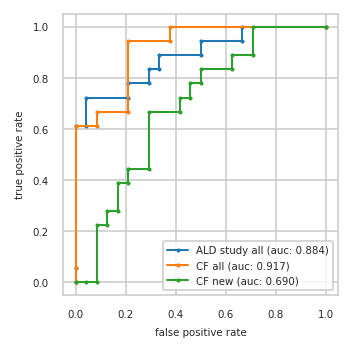

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.611  0.000 0.611  0.083 0.000
3          0.042 0.611  0.083 0.611  0.083 0.222
4          0.042 0.722  0.083 0.667  0.125 0.222
5          0.208 0.722  0.208 0.667  0.125 0.278
6          0.208 0.778  0.208 0.944  0.167 0.278
7          0.292 0.778  0.375 0.944  0.167 0.389
8          0.292 0.833  0.375 1.000  0.208 0.389
9          0.333 0.833  1.000 1.000  0.208 0.444
10         0.333 0.889    NaN   NaN  0.292 0.444
11         0.500 0.889    NaN   NaN  0.292 0.667
12         0.500 0.944    NaN   NaN  0.417 0.667
13         0.667 0.944    NaN   NaN  0.417 0.722
14         0.667 1.000    NaN   NaN  0.458 0.722
15         1.000 1.000    NaN   NaN  0.458 0.778
16           NaN   NaN    NaN   NaN  0.500 0.778
17           NaN   NaN    NaN   NaN  0.500 0.833
18           NaN   NaN    NaN   NaN  0.625 0.833
19           NaN   NaN    NaN   NaN  0.625 0.889
20           NaN   NaN    NaN   NaN  0.708 0.889
21           NaN   NaN    NaN   NaN  0.708 1.000
22           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P07998,Q92765,G3V295;G3V3I1;G3V5Z7;P60900
2,A0A075B6R2,B8ZZ19;H0Y3U0;P20472,P51688
3,P01033;Q5H9A7,A2A2D0;P16949;P16949-2,E7EPV7;P37840;P37840-2
4,P61981,P04075,P31321
5,P04075,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,P14174,P61981,A0A075B7B8
7,Q9Y2T3;Q9Y2T3-3,Q14894,None
8,P00338;P00338-3,P51688,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


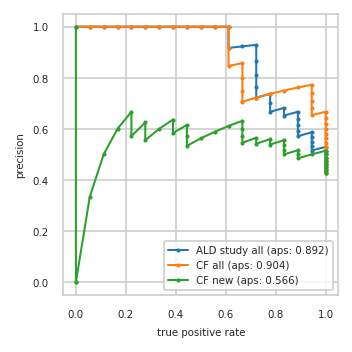

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.586 0.944     0.621 1.000     0.517 0.833
14         0.571 0.889     0.643 1.000     0.536 0.833
15         0.593 0.889     0.667 1.000     0.556 0.833
16         0.615 0.889     0.654 0.944     0.538 0.778
17         0.640 0.889     0.680 0.944     0.560 0.778
18         0.667 0.889     0.708 0.944     0.542 0.722
19         0.652 0.833     0.739 0.944     0.565 0.722
20         0.682 0.833     0.773 0.944     0.545 0.667
21         0.667 0.778     0.762 0.889     0.571 0.667
22         0.700 0.778     0.750 0.833     0.600 0.667
23         0.737 0.778     0.737 0.778     0.632 0.667
24         0.722 0.722     0.722 0.722     0.611 0.611
25         0.765 0.722     0.706 0.667     0.588 0.556
26         0.812 0.722     0.750 0.667     0.562 0.500
27         0.867 0.722     0.800 0.667     0.533 0.444
28         0.929 0.722     0.857 0.667     0.571 0.444
29         0.923 0.667     0.846 0.611     0.615 0.444
30         0.917 0.611     0.917 0.611     0.583 0.389
31         1.000 0.611     1.000 0.611     0.636 0.389
32         1.000 0.556     1.000 0.556     0.600 0.333
33         1.000 0.500     1.000 0.500     0.556 0.278
34         1.000 0.444     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


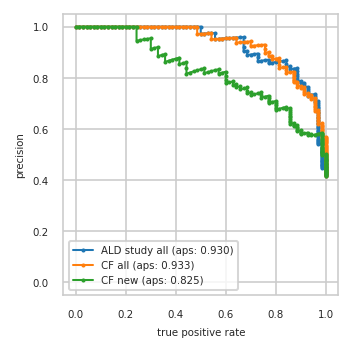

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


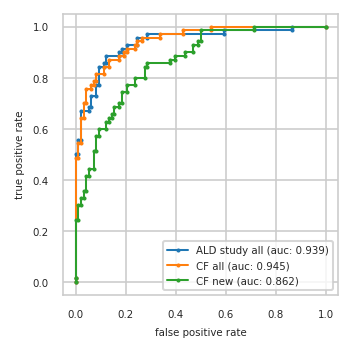

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}